In [1]:
# including the project directory to the notebook level
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
#importing modules

#modules for data reading and parsing dates
from dataprocess import dataprocessor as dp

# Get the raw VRF data from csv files

In [3]:
# load data path
vrfdata = dp.readfolder('../data/raw/VRF_setpoint/',
                        timeformat='%Y-%m-%d %H:%M:%S',
                        dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['files2dflist', 'datetime_parse_dflist', 'merge_dflist']
vrf = vrfdata.return_df(processmethods=processmethods)

Finished 'dataframeplot' in 3.2416 secs


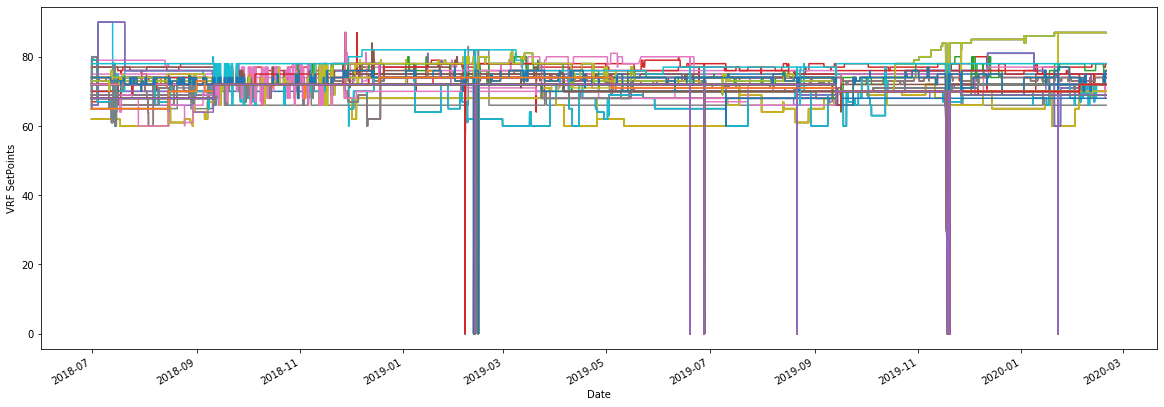

In [4]:
# Drop Columns where >5% of values are missing
vrf = dp.dropNaNcols(vrf, threshold=0.95)

# Drop columns of constant values if needed
vrf = dp.constantvaluecols(vrf, limit=0.2)

# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

### This data has collective outliers. So we remove them based on bounds


Retaining 97.79391149946264% of the data
Finished 'removeoutliers' in 12.9285 secs
Finished 'dataframeplot' in 3.6786 secs


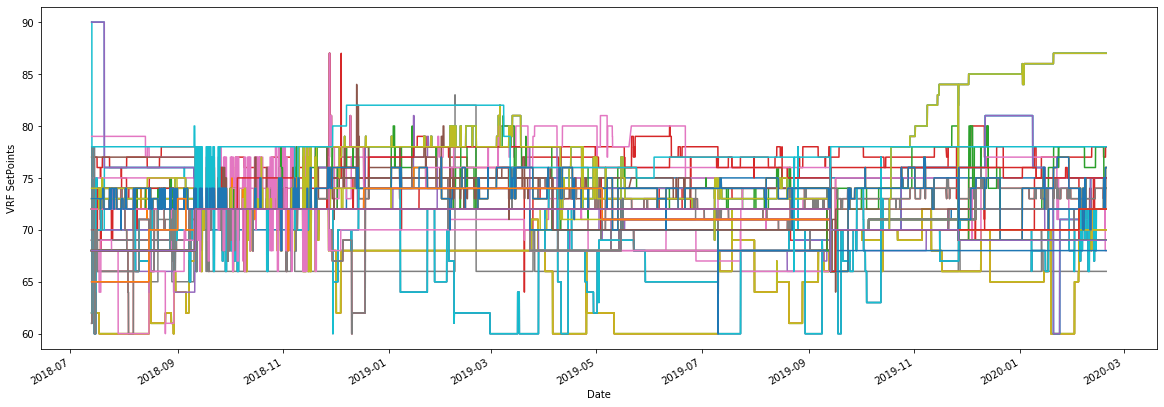

In [5]:
# remove outliers based on bounds
vrf = dp.removeoutliers(vrf,
                        columns=vrf.columns,
                        upperbound=100,
                        lowerbound=40)

# Plot the df
dp.dataframeplot(vrf, ylabel='VRF SetPoints', xlabel='Date', style='-')

In [6]:
# saving the data
vrf.to_pickle('../data/processed/vrf.pkl')

# Get the raw Alumni AHU data from CSV files

In [3]:
# load data path
ahudata = dp.readfile('../data/raw/energyvars/File1.csv',
                      timeformat='%Y-%m-%d %H:%M:%S+00:00',
                      dateheading='time')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
ahu = ahudata.return_df(processmethods=processmethods)

In [4]:
# drop cooling tower humidity infos as they contain constant values which seem unreliable
ahu = ahu.drop(
    columns=['Chiller_1 outdoorAirHumidity', 'CT_2 outdoorAirHumidity'])

# Drop Columns where >5% of values are NaN
ahu = dp.dropNaNcols(ahu, threshold=0.95)

# Drop rows with NaN
ahu = dp.dropNaNrows(ahu)

Finished 'dataframeplot' in 0.6318 secs


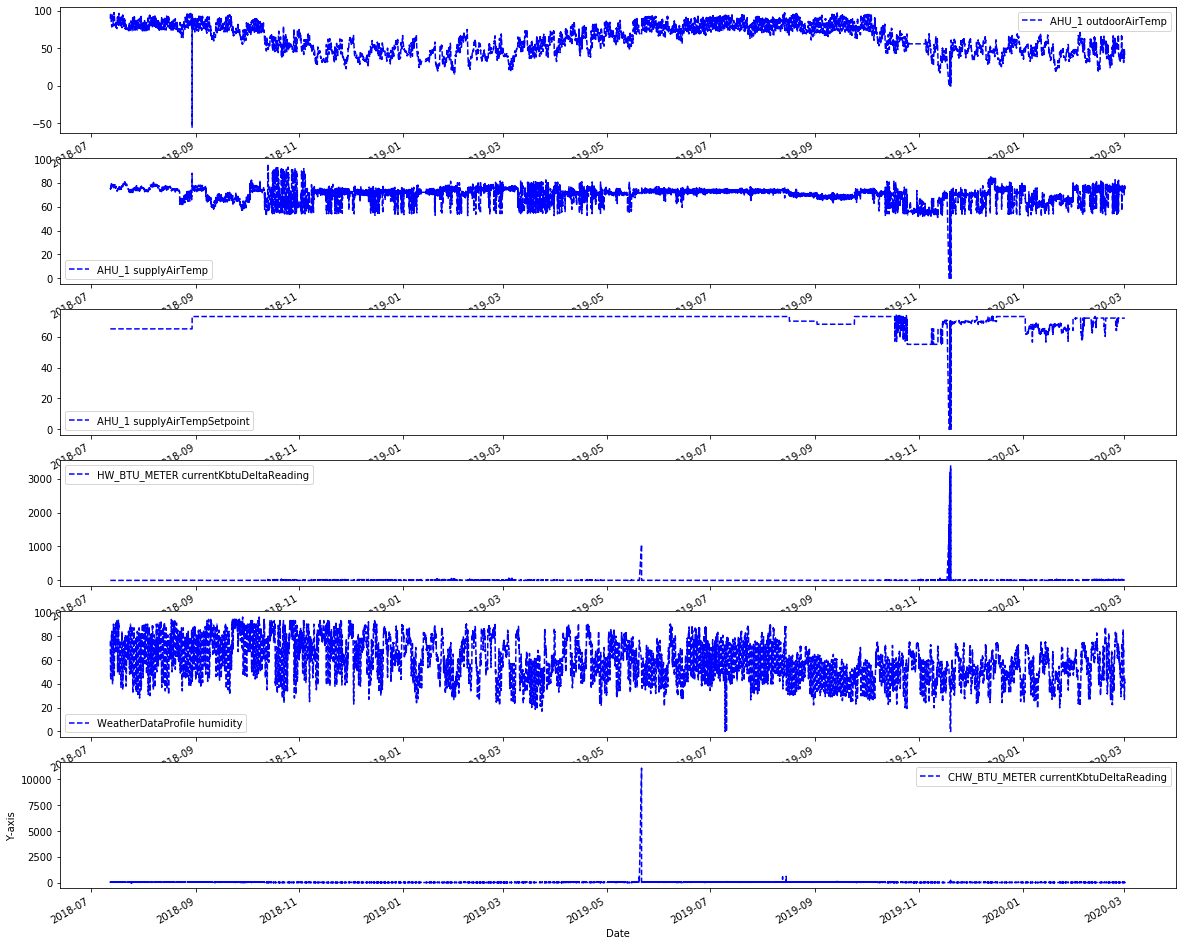

In [5]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True)

### Some data incorporate both statistical outliers and collective point outliers. We have to first remove the collective point outliers to perform meaningful statistical outlier based removal

In [6]:
# remove outleirs based on bounds
# 1 remove on hw energy bounds
# 2 remove on chw energy bounds
# 3 remove on setpoint bounds
# 4 remove on supply air temperature
# 5  remove on outside air temeprature
name = ['AHU_1 supplyAirTempSetpoint', 'HW_BTU_METER currentKbtuDeltaReading',\
        'CHW_BTU_METER currentKbtuDeltaReading', 'AHU_1 supplyAirTemp', 'AHU_1 outdoorAirTemp']
u_bound = [90, 500, 100, 90, 120]
l_bound = [40, -1, -1, 40, -10]
for i in range(len(name)):
    ahu = dp.removeoutliers(ahu,
                            columns=[name[i]],
                            upperbound=u_bound[i],
                            lowerbound=l_bound[i])


Retaining 99.84957212928602% of the data
Finished 'removeoutliers' in 7.7533 secs



Retaining 99.99765518292504% of the data
Finished 'removeoutliers' in 7.8676 secs



Retaining 99.99531025588416% of the data
Finished 'removeoutliers' in 7.7762 secs



Retaining 99.95016913182903% of the data
Finished 'removeoutliers' in 7.8108 secs



Retaining 99.99765384886095% of the data
Finished 'removeoutliers' in 7.8031 secs


In [7]:
# remove outliers based on z-thresh
col_list = [
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'WeatherDataProfile humidity', 'HW_BTU_METER currentKbtuDeltaReading'
]
ahu = dp.removeoutliers(ahu, columns=col_list, z_thresh=3)

Retaining 98.22157571207357% of the data
Finished 'removeoutliers' in 0.5931 secs


Finished 'dataframeplot' in 0.4855 secs


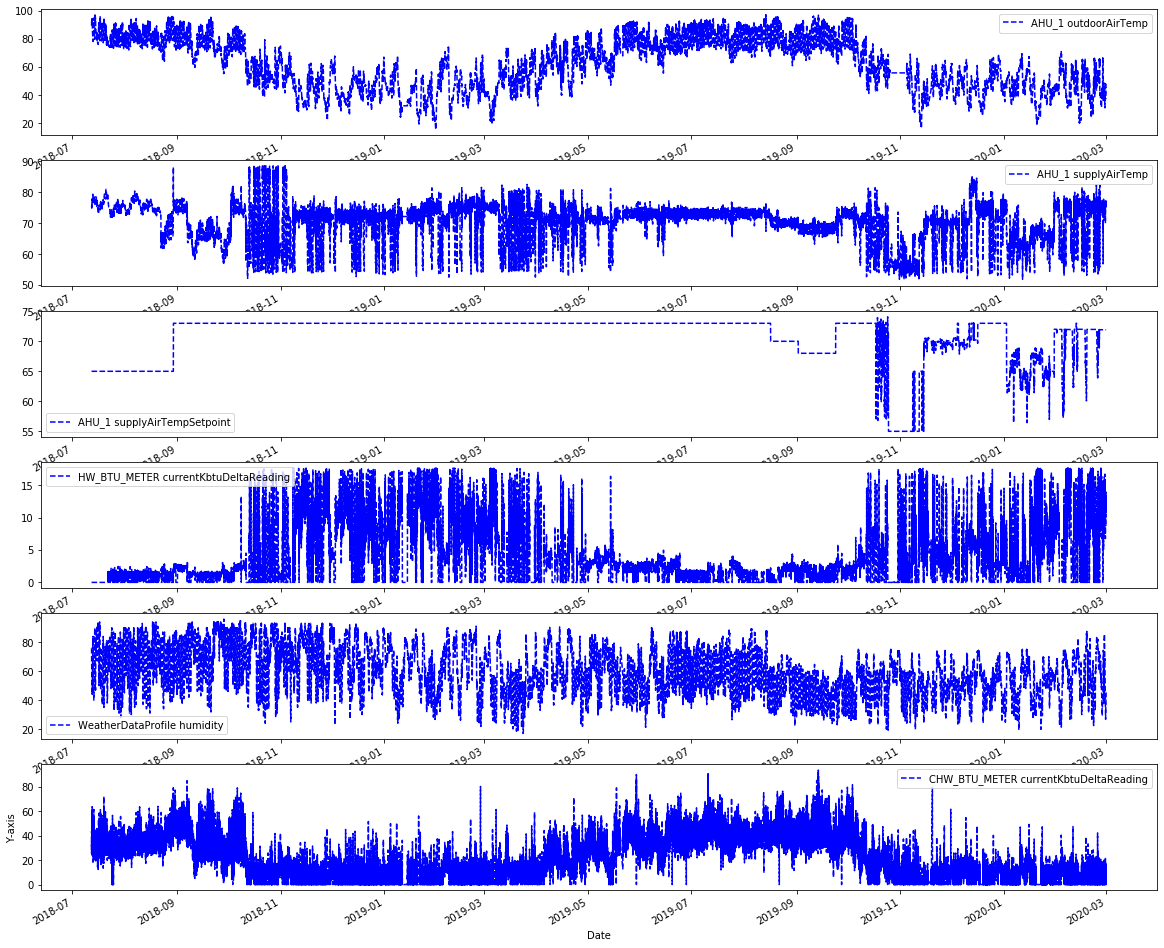

In [8]:
# Plot the df
dp.dataframeplot(ahu, xlabel='Date', lazy=False, legend=True)

In [9]:
# rearange cols for later use
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'AHU_1 supplyAirTemp',
    'AHU_1 supplyAirTempSetpoint', 'WeatherDataProfile humidity',
    'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# save the data in pickeld format
ahu.to_pickle('../data/processed/ahu1energy.pkl')

# Get raw solar GHI information

In [3]:
# get old solar irradiation data from july 12th 2018 to Oct 23rd 2019

# load data path
olddata = dp.readfile('../data/raw/solardata/RL_relearn_data_v2.pkl')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df']
olddf = olddata.return_df(processmethods=processmethods)

# We need only ghi data
olddf = olddf[['Ghi']]

In [5]:
# get new Solar irradiation data from Oct 23rd 2019 to present data

# load data path
newdata = dp.readfile('../data/raw/solardata/Nashville_Solcast_PT5M.csv',
                     dateheading="PeriodEnd", timeformat='%Y-%m-%dT%H:%M:%SZ')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
newdf = newdata.return_df(processmethods=processmethods)

# Since it still contains many redundant cols we retain only Ghi
newdf = newdf[['Ghi']]

In [6]:
# merge old and new solar irradiation data
ghidf = dp.mergerows([olddf, newdf])

In [11]:
ghidf.head()

,Ghi
2018-07-12 08:55:00,745.0
2018-07-12 09:00:00,758.0
2018-07-12 09:05:00,772.0
2018-07-12 09:10:00,785.0
2018-07-12 09:15:00,798.0


In [13]:
# removing statistical outliers if any
# remove outliers based on z-thresh
col_list = ['Ghi']
ghidf = dp.removeoutliers(ghidf, columns=col_list, z_thresh=3)

Retaining 98.95114006514657% of the data
Finished 'removeoutliers' in 0.0153 secs


Finished 'dataframeplot' in 0.1027 secs


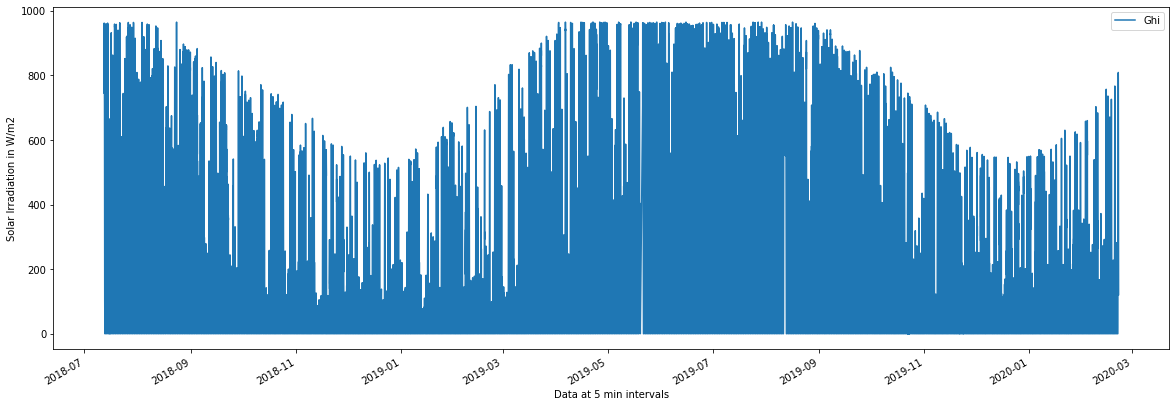

In [14]:
dp.dataframeplot(df=ghidf,
                 style='-',
                 xlabel='Data at 5 min intervals',
                ylabel='Solar Irradiation in W/m2',
                legend=True)

In [15]:
# Saving the processed data
ghidf.to_pickle('../data/processed/ghi.pkl')

# Get raw Primary Chilled Water Flow information

In [11]:
# load data path
flowdata = dp.readfile('../data/raw/energyvars/2020-03-10_1703_dataExport.csv',
                      timeformat='%Y-%m-%d %H:%M:%S',
                      dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
flow = flowdata.return_df(processmethods=processmethods)

Finished 'dataframeplot' in 0.0924 secs


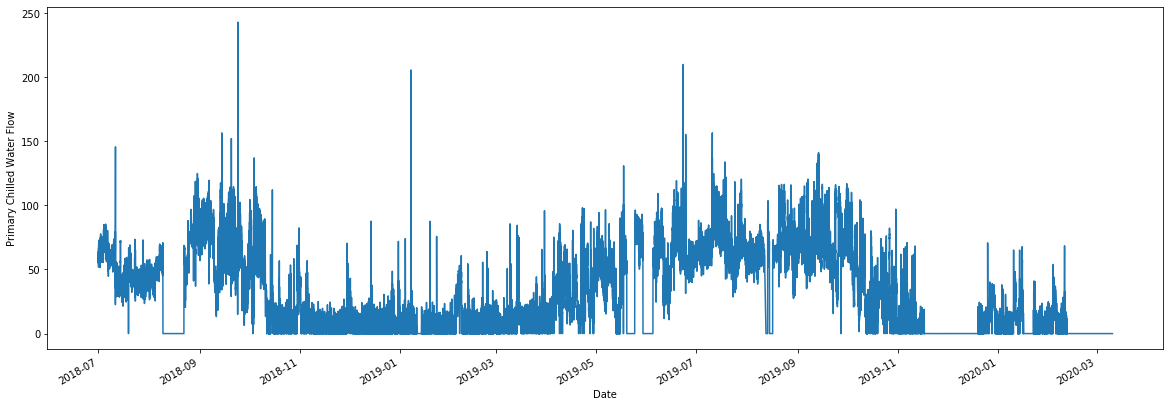

In [12]:
# Drop rows with NaN
flow = dp.dropNaNrows(flow)

# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='-')

### It has point outliers at this point. Let us first remove them


Retaining 80.72854534044201% of the data
Finished 'removeoutliers' in 7.9201 secs



Retaining 100.0% of the data
Finished 'removeoutliers' in 7.4150 secs
Finished 'dataframeplot' in 0.0683 secs


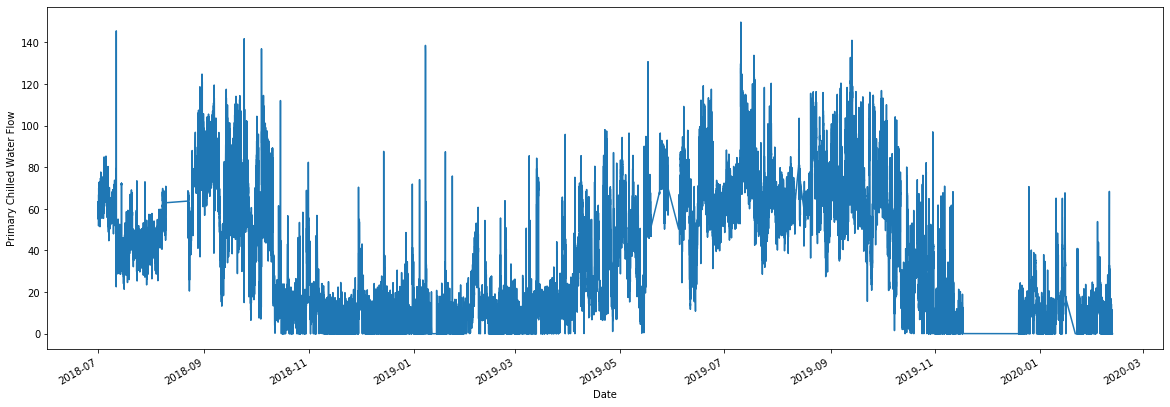

In [13]:
# remove outleirs based on bounds
name = ['Alumni_Hall_PCHW_Flow.value']
u_bound = [150]
l_bound = [0]
for i in range(len(name)):
    flow = dp.removeoutliers(flow,
                            columns=[name[i]],
                            upperbound=u_bound[i],
                            lowerbound=l_bound[i])
    
# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='-')

In [ ]:
# removing statistical outliers if any
# remove outliers based on z-thresh
col_list = ['Alumni_Hall_PCHW_Flow.value']
flow = dp.removeoutliers(flow, columns=col_list, z_thresh=3)

Finished 'dataframeplot' in 0.0889 secs


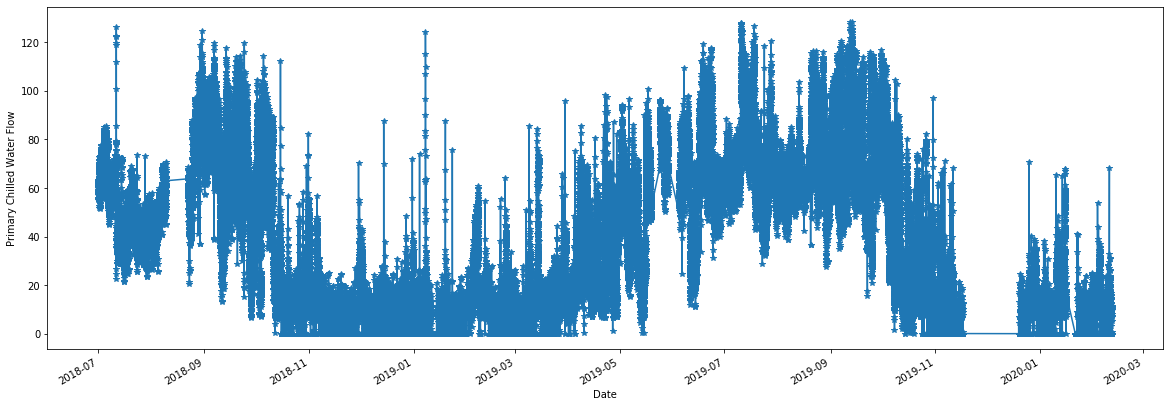

In [15]:
# Plot the df
dp.dataframeplot(flow, ylabel='Primary Chilled Water Flow', xlabel='Date', style='-*')

In [17]:
# Saving the processed data
flow.to_pickle('../data/processed/flow.pkl')

# Get Hotwater Flow and supply temperature data

In [10]:
# load data path
hwdata = dp.readfile('../data/raw/energyvars/AH_Boiler_HW.csv',
                     timeformat='%m/%d/%Y %H:%M',
                     dateheading='Date')

# Basic preprocessing read data and perform certain available operations and return processed dataframe
processmethods = ['file2df', 'datetime_parse_df']
hw = hwdata.return_df(processmethods=processmethods)
hw = hw[[
    'HW_System.hwReturnTemp',
    'HW_System.hwSupplyFlow',
    'HW_System.hwSupplyTemp',
    'HW_System.hwSupplyTempSetpoint',
]]

In [11]:
hw.head()

,HW_System.hwReturnTemp,HW_System.hwSupplyFlow,HW_System.hwSupplyTemp,HW_System.hwSupplyTempSetpoint
Time,,,,
2018-11-16 10:05:00,98.22113,6.715617,107.05994,116.83555
2018-11-16 10:10:00,100.06567,6.831125,114.65901,116.43321
2018-11-16 10:15:00,98.33179,8.241195,117.93087,116.03993
2018-11-16 10:20:00,95.43451,9.518204,112.28122,115.65360
2018-11-16 10:25:00,92.90832,9.752769,109.42430,114.87598


In [12]:
# Drop Columns where >5% of values are NaN
hw = dp.dropNaNcols(hw, threshold=0.95)

# Drop rows with NaN
hw = dp.dropNaNrows(hw)

In [13]:
# remove outliers based on z-thresh
col_list = [
    'HW_System.hwSupplyFlow', 'HW_System.hwSupplyTemp'
]
hw_cleaned = dp.removeoutliers(hw, columns=col_list, z_thresh=3)

Retaining 99.5800759437123% of the data
Finished 'removeoutliers' in 0.0277 secs


In [ ]:
# Plot the df
dp.dataframeplot(hw_cleaned, xlabel='Date', lazy=False, legend=True)

In [14]:
#rename columns
hw_cleaned.columns = ['hw_rt','hw_sf','hw_st','hw_s_stp']

In [16]:
# save the data in pickeld format
hw_cleaned.to_pickle('../data/processed/hw_data.pkl')

# Combining all 5 dataframes


In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')
# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])



# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')
# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])
ghi.columns = ['ghi']



# read the pickled file for vrf data
vrfdata = dp.readfile('../data/processed/vrf.pkl')
# return pickled df
vrf = vrfdata.return_df(processmethods=['file2df'])
# create row average
vrf['avg_stpt'] = vrf.mean(axis=1)
# drop cassette wise information
vrf.drop(columns=vrf.columns[:-1], inplace=True)



# read the pickled file for chilled water flow data
flowdata = dp.readfile('../data/processed/flow.pkl')
# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']



# read the pickled file for hot water data
hwdata = dp.readfile('../data/processed/hw_data.pkl')
# return pickled df
hw = hwdata.return_df(processmethods=['file2df'])

In [4]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, vrf, flow, hw])

In [5]:
# renaming columns
df.columns = ['oat','sat', 'sat_stpt', 'orh', 'hwe', 'cwe', 'ghi', 'avg_stpt', 'flow','hw_rt','hw_sf','hw_st','hw_s_stp']

# selecting relevant columns
df = df[['oat','sat',  'orh', 'hwe', 'cwe', 'ghi', 'avg_stpt', 'flow','hw_sf','hw_st','hw_rt']]

In [6]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.090181,73.392624,85.0,12.266188,0.0,524.0,72.438095,0.004395,6.715617,107.05994,98.22113
2018-11-16 10:10:00,31.090181,72.792236,85.0,11.701546,0.0,530.0,72.438095,0.002403,6.831125,114.65901,100.06567
2018-11-16 10:15:00,31.090181,72.495117,85.0,11.578586,0.0,537.0,72.438095,0.004492,8.241195,117.93087,98.33179
2018-11-16 10:20:00,31.090181,72.495117,85.0,11.693608,0.0,543.0,72.438095,0.003086,9.518204,112.28122,95.43451
2018-11-16 10:25:00,31.090181,72.495117,85.0,11.269130,0.0,549.0,72.438095,0.006318,9.752769,109.42430,92.90832


In [7]:
df.to_pickle('../data/processed/buildingdata.pkl')

In [8]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.08
)

In [9]:
df_smoothed.to_pickle('../data/processed/smoothed_buildingdata.pkl')

# Looking at frequency properties of the data

In [3]:
# read the pickled file for ahu data
ahudata = dp.readfile('../data/processed/ahu1energy.pkl')

# return pickled df
ahu = ahudata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
ghidata = dp.readfile('../data/processed/ghi.pkl')

# return pickled df
ghi = ghidata.return_df(processmethods=['file2df'])

# read the pickled file for ghi data
flowdata = dp.readfile('../data/processed/flow.pkl')

# return pickled df
flow = flowdata.return_df(processmethods=['file2df'])
flow.columns = ['flow']

In [4]:
# selecting only required columns and rearranging them
ahu = ahu[[
    'AHU_1 outdoorAirTemp', 'WeatherDataProfile humidity',
    'AHU_1 supplyAirTemp', 'HW_BTU_METER currentKbtuDeltaReading',
    'CHW_BTU_METER currentKbtuDeltaReading'
]]

# renaming columns
ahu.columns = ['oat', 'orh', 'sat', 'hwe', 'cwe']

# # Total energy is sum of heating and coling
# ahu['totale'] = ahu['hwe'] + ahu['cwe']
# # dropping heating and cooling energy columns
# ahu = ahu.drop(columns=['hwe', 'cwe'])

In [11]:
# merging ahu and ghi data
df = dp.merge_df_columns([ahu, ghi, flow])

Finished 'dataframeplot' in 0.5069 secs


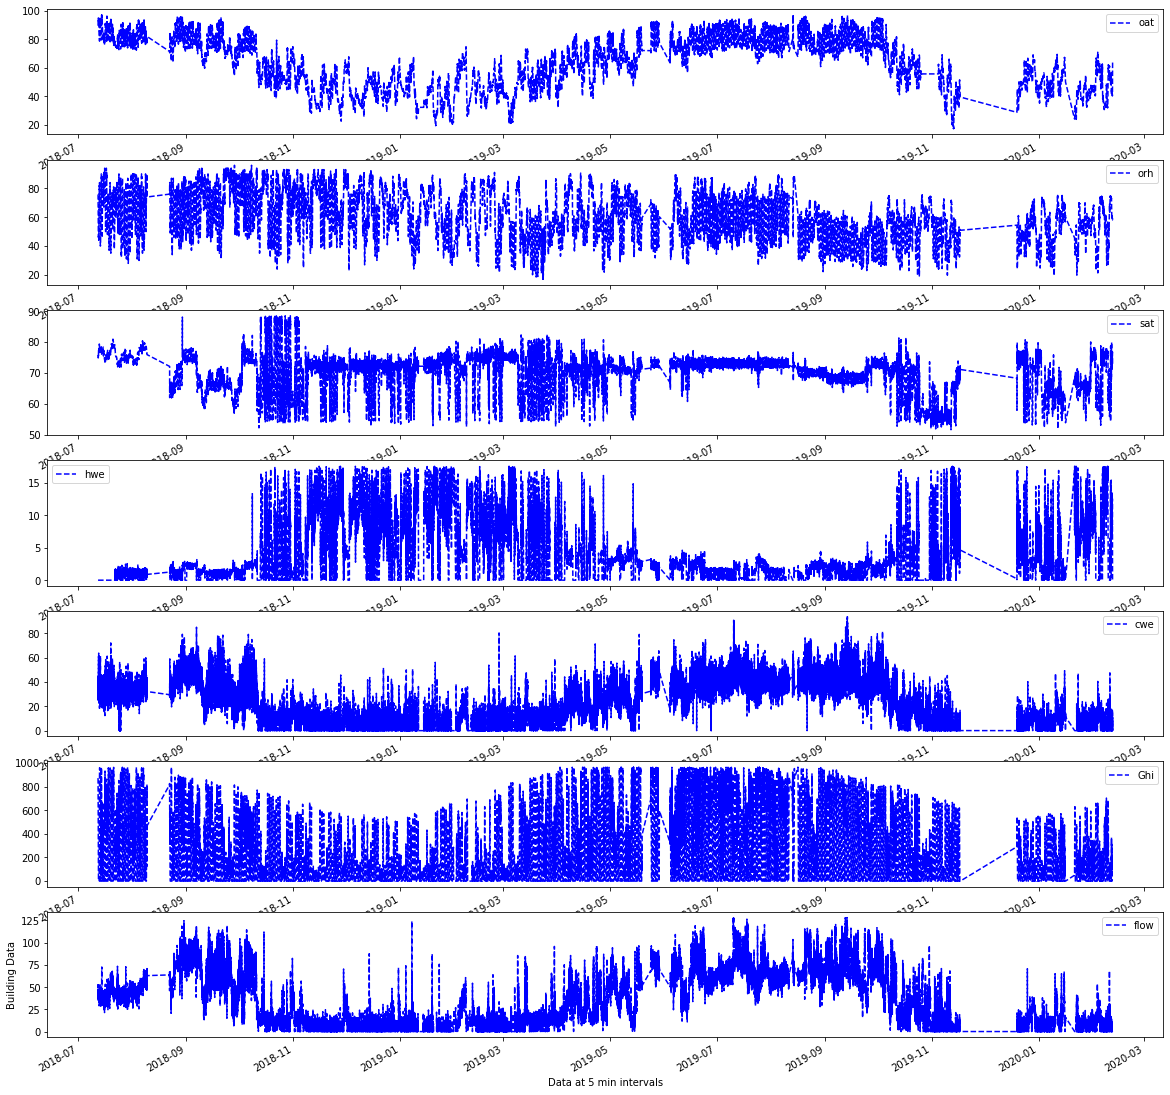

In [12]:
dp.dataframeplot(df=df,
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

In [ ]:
# smooth the hwe and cwe
df_smoothed = dp.dfsmoothing(
    df,
    column_names=list(df.columns),
    Wn=0.15
)

Finished 'dataframeplot' in 0.7170 secs


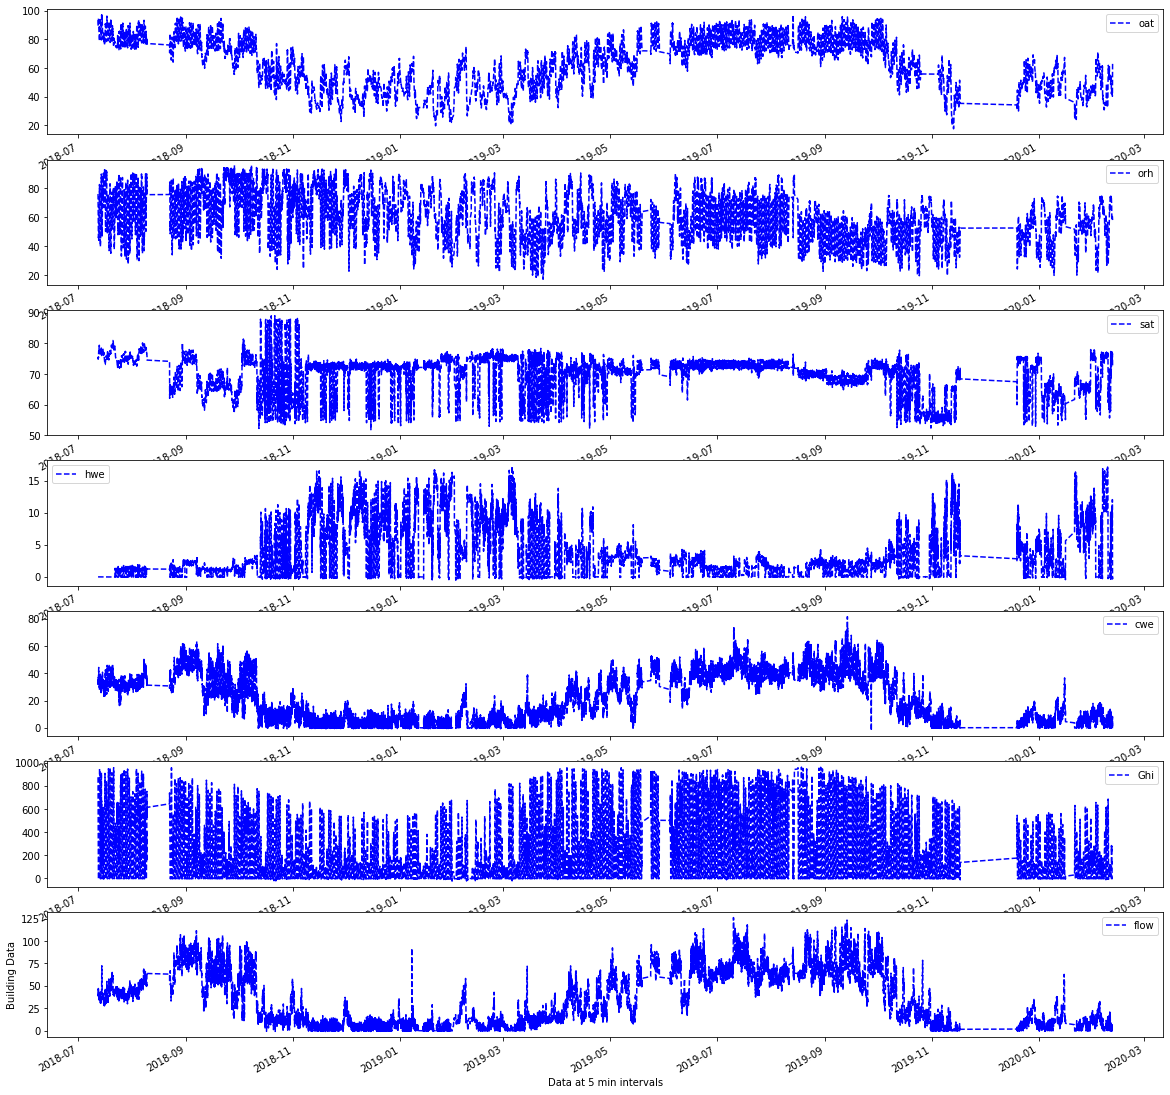

In [31]:
dp.dataframeplot(df=df_smoothed,
                 style='-',
                 xlabel='Data at 5 min intervals',
                 ylabel='Building Data',
                 legend=True,
                 lazy=False)

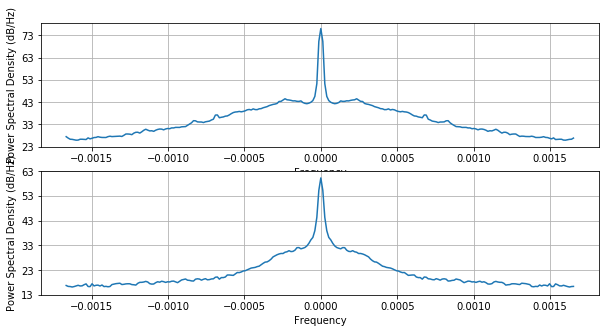

In [25]:
import matplotlib.pyplot as plt

cwe = df['cwe'].to_numpy().flatten()
hwe = df['hwe'].to_numpy().flatten()
dt = 300

plt.rcParams["figure.figsize"] = (10,5)

plt.subplot(211)
plt.psd(cwe, NFFT=256, Fs=1/dt, sides='twosided')


plt.subplot(212)
plt.psd(hwe, 256, 1 / dt, sides='twosided')

plt.show()

In [33]:
# Total energy is sum of heating and coling
df_smoothed['totale'] = df_smoothed['hwe'] + df_smoothed['cwe']
# dropping heating and cooling energy columns
df_smoothed = df_smoothed.drop(columns=['hwe', 'cwe'])

# dp.dataframeplot(df=df_smoothed,
#                  style='-',
#                  xlabel='Data at 5 min intervals',
#                  ylabel='Building Data',
#                  legend=True,
#                  lazy=False)

In [34]:
df_smoothed.to_pickle('../data/processed/smoothbuildingdata.pkl')

# Correlation between signals

In [3]:
# read the pickled file for ahu data
dfdata = dp.readfile('../data/processed/smoothed_buildingdata.pkl')

# return pickled df
df = dfdata.return_df(processmethods=['file2df'])

In [4]:
df.head()

,oat,sat,orh,hwe,cwe,ghi,avg_stpt,flow,hw_sf,hw_st,hw_rt
2018-11-16 10:05:00,31.085561,73.399236,84.996351,12.247199,0.061145,523.448686,72.438053,0.004498,6.769096,107.185437,98.426348
2018-11-16 10:10:00,31.084241,73.174948,85.162961,12.049303,1.239401,530.628172,72.436722,0.004635,7.174604,108.380930,97.960950
2018-11-16 10:15:00,31.082809,72.953222,85.338500,11.855933,2.364778,537.912446,72.435385,0.004748,7.570829,109.490329,97.490620
2018-11-16 10:20:00,31.081329,72.737975,85.531478,11.673648,3.409979,545.266988,72.434065,0.004843,7.942075,110.468679,97.028119
2018-11-16 10:25:00,31.079893,72.531779,85.748990,11.508193,4.338237,552.652147,72.432798,0.004924,8.275292,111.291654,96.587022


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

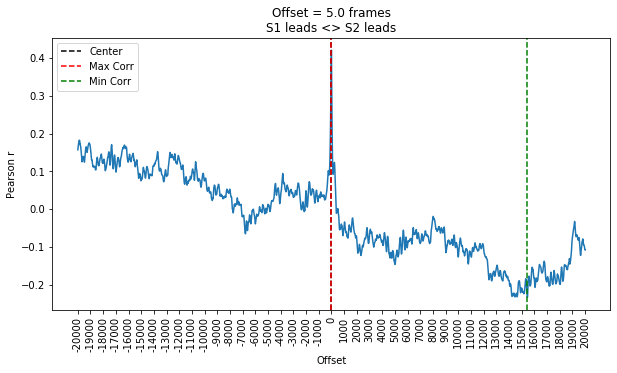

In [7]:
d1 = df['hwe']
d2 = df['sat']
seconds = 20000
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((seconds+1)*fps), 1000))
ax.set_xticklabels(np.arange(-int(seconds*fps),int((seconds+1)*fps),1000), rotation=90);
plt.legend()

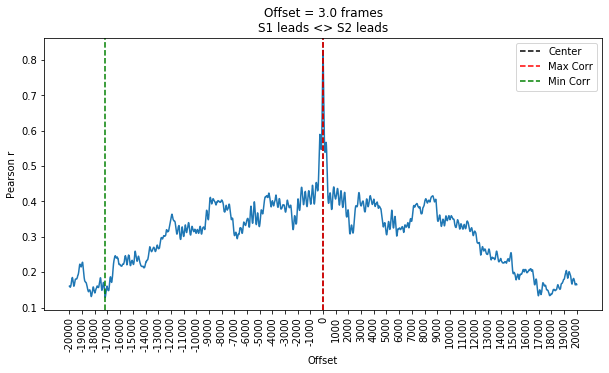

In [8]:
d1 = df['hwe']
d2 = df['sat']-df['oat']
seconds = 20000
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((seconds+1)*fps), 1000))
ax.set_xticklabels(np.arange(-int(seconds*fps),int((seconds+1)*fps),1000), rotation=90);
plt.legend()

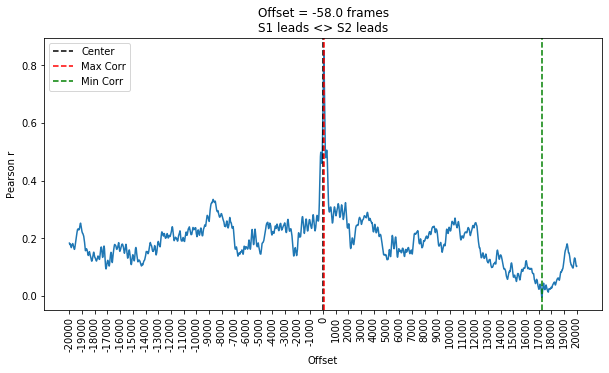

In [9]:
d1 = df['hwe']
d2 = df['hw_sf']
seconds = 20000
fps = 1 # 1 unit = 5 mins
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.ceil(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(10,5))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Max Corr')
ax.axvline(np.argmin(rs),color='g',linestyle='--',label='Min Corr')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(np.arange(0,2*int((seconds+1)*fps), 1000))
ax.set_xticklabels(np.arange(-int(seconds*fps),int((seconds+1)*fps),1000), rotation=90);
plt.legend()